# Nitrate Concentration Prediction - Base Model
In this notebook, we build a simple model consisting of predicting the Nitrate Concentration in the water with this two features :
- day of the year
- Mean Nitrate concentration measured at the station considered

This simple NN model is for reference.


In [2]:
import os, re
from dotenv import dotenv_values

from sqlalchemy import create_engine, text

from datetime import date,datetime,timedelta
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

import requests

## Data Import
The data used to train the model has been prepared in the data_constitution.ipynb. The corresponding pickle file is imported

In [3]:
data = pd.read_pickle('../data/prepared_data.pkl')

# Base Model Implementation

In [5]:
from tensorflow.keras import models, layers, regularizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Normalization
import tensorflow as tf

In [6]:
feat_cols = [
    'mean_nitrate',
    'sin_doy',
    'cos_doy',
]

In [8]:
df = data.copy()

# Retreiving Data for visualisation
VAL_STATION = 6045800
val_rows = (df['station_id'] == VAL_STATION) & (df['day'] > datetime(year=2016,month=1,day=1))

df_val = df[val_rows].copy()
df = df[df['station_id'] != VAL_STATION].copy()
X_val = df_val[feat_cols]
y_val=df_val['measure']

# Features, Target
X = df[feat_cols]
y = df['measure']

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)


In [10]:
def init_model(X_train):
    
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    regl2 = regularizers.L2(0.001)
    
    model = models.Sequential()
    
    model.add(normalizer)
    
    model.add( layers.Dense(80,activation='relu',kernel_regularizer=regl2) )
    model.add( layers.Dropout(rate=0.2) )
    model.add( layers.Dense(40,activation='relu',kernel_regularizer=regl2) )
    model.add(layers.Dropout(rate=0.4))
    
    model.add( layers.Dense(20,activation='relu',kernel_regularizer=regl2) )
    model.add(layers.Dropout(rate=0.5))
    
    
    model.add(layers.Dense(1,activation='linear'))
    
    model.compile(loss='mse', optimizer='adam',metrics=[tf.keras.metrics.RootMeanSquaredError('rmse')])
    
    return model

model = init_model(X_train)


es = EarlyStopping(
	patience=20,
	monitor='val_loss',
	restore_best_weights=True
)

history = model.fit(
	X_train,y_train,
	epochs=2000,  # set it to a large value, early stoping will stop the fit
	batch_size=16, # good values : 16 or 32
	callbacks=[es],
	validation_data=(X_test, y_test),
	verbose=0
)

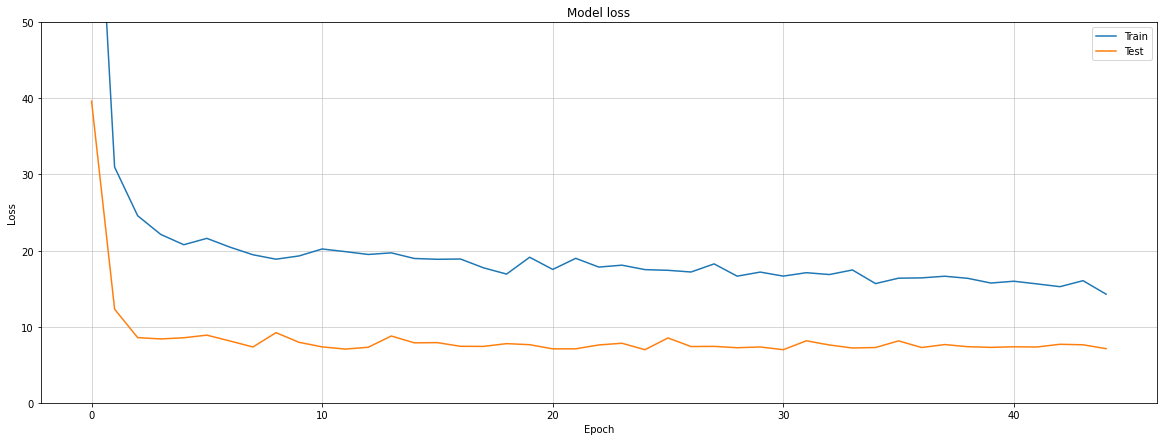

In [11]:
def plot_loss(history, title=None):
    fig = plt.figure(figsize=(20,7))
    
    # --- LOSS --- 
    ax = plt.gca()
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title('Model loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylim((0,50))
    ax.legend(['Train', 'Test'], loc='best')
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

plot_loss(history)

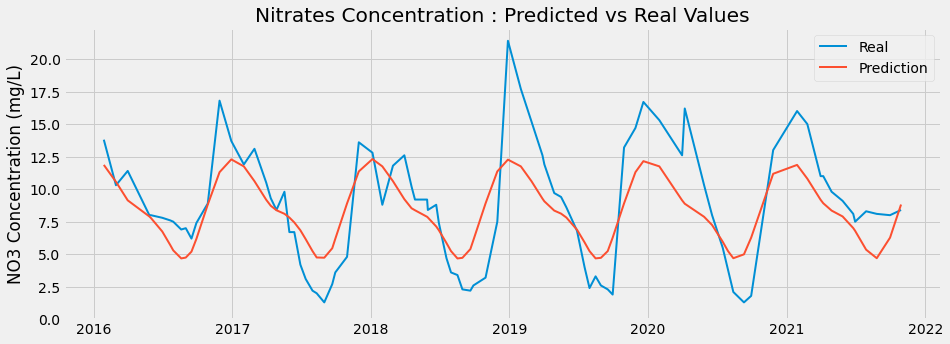

In [13]:
# Visualization of the predicted and real values when predicting on unseen data
y_pred = model.predict(X_val)
df_val['prediction'] = y_pred

df_val.sort_values('day',inplace=True)

with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(14,5))
    plt.title('Nitrates Concentration : Predicted vs Real Values')
    plt.plot(df_val['day'],df_val['measure'],label='Real',linewidth=2)
    plt.plot(df_val['day'],df_val['prediction'],label='Prediction',linewidth=2)
    plt.ylim(bottom=0)
    plt.ylabel('NO3 Concentration (mg/L)')
    plt.legend()
    plt.show()

# Model Evaluation

In [14]:
from sklearn.model_selection import KFold

In [16]:
df = data.copy()

# Features, Target
X = df[feat_cols].to_numpy()
y = df['measure'].to_numpy()

# K-Fold Cross Validation model evaluation
fold_n = 1
folds_rmse = []
folds_loss = []

kfold = KFold(n_splits=10, shuffle=True)

for train, test in kfold.split(X,y):
    
    model = init_model(X[train])
    print(f'Training for fold {fold_n}...')

    history = model.fit(
        X[train],y[train],
        epochs=10,
        batch_size=16,
        verbose=0
    )
    
    scores = model.evaluate(X[test],y[test],verbose=0)
    folds_rmse.append(scores[1])
    folds_loss.append(scores[0])
    
    fold_n += 1
    
print(f'\nAverage RMSE : {np.mean(folds_rmse)}')
print(f'Average loss : {np.mean(folds_loss)}')


Training for fold 1...
Training for fold 2...
Training for fold 3...
Training for fold 4...
Training for fold 5...
Training for fold 6...
Training for fold 7...
Training for fold 8...
Training for fold 9...
Training for fold 10...

Average RMSE : 2.939609909057617
Average loss : 8.788521766662598
